In [1]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
import uproot
#import root_pandas as rpd
#from root_pandas import read_root
from matplotlib import rc

mpl.rcParams.update({'font.size': 18})
mpl.rcParams.update({'legend.fontsize': 20})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
rc('font', weight='bold')
colors = {}
colors['C'] = '#1f77b4'
colors['Fe'] = '#ff7f0e'
colors['Pb']=  '#2ca02c'

Welcome to JupyROOT 6.22/09


In [2]:
def getRatio(df_A,df_D,df_trigger_A,df_trigger_D, variable='h2_z',trig_cut = 'h1_z>0.5', pair_cut='',minz=0.05,
             maxz=0.5,nbins=9, applyweight=False):
    
    print ('Print Trigger Cut ' ,trig_cut)
    print ('Total Cut ', trig_cut + pair_cut)
    norm_A = df_trigger_A.query(trig_cut).shape[0] 
    norm_D = df_trigger_D.query(trig_cut).shape[0]
    bins= np.linspace(minz,maxz,nbins)
    y_A, x_conditional = np.histogram(df_A.query(trig_cut+pair_cut)[variable],bins=bins)
    y_D, x_conditional = np.histogram(df_D.query(trig_cut+pair_cut)[variable],bins=bins)
    erry_A, x_conditional = np.histogram(df_A.query(trig_cut+pair_cut)[variable],bins=bins)
    erry_D, x_conditional = np.histogram(df_D.query(trig_cut+pair_cut)[variable],bins=bins)
    x_conditional = (x_conditional[1:] + x_conditional[:-1])/2.0
    err_A = np.true_divide(np.sqrt(erry_A),y_A)
    err_D = np.true_divide(np.sqrt(erry_D),y_D)
    y_A = np.true_divide(y_A,norm_A)
    y_D = np.true_divide(y_D,norm_D)
    ratio_conditional = np.true_divide(y_A,y_D)
    error_conditional = np.multiply(ratio_conditional, np.sqrt(np.power(err_A,2.0) + np.power(err_D,2.0)))
    return ratio_conditional,error_conditional,x_conditional


In [3]:
def applyCut(inputDataframe, cut, text=None):
    nbeforecut = inputDataframe.shape[0]
    cutDataframe = None
    if nbeforecut>0:
        cutDataframe = inputDataframe.query(cut)
        if text:
            print (text, cutDataframe.shape[0], ' (%2.2f '%(100.0*cutDataframe.shape[0]/nbeforecut), '%)')
    return cutDataframe

def applyCuts(fullDataframe,name='default',isMC=False,isTrigger=True): 
    dataframe = fullDataframe
    if(dataframe.shape[0]>0):
        print ('Entries before cut ', dataframe.shape[0])
    dataframe.eval('inelasticity = nu/5.014', inplace=True)
    dataframe.eval('h1_e = h1_z*nu', inplace=True)
    dataframe.eval('h1_p = sqrt(h1_e*h1_e-0.13957*0.13957)', inplace=True)
    dataframe = applyCut(dataframe, 'Q2>1.0 and Q2<4.0', 'Q2>1.0 and Q2<4.0')
    dataframe = applyCut(dataframe, 'inelasticity<0.85','inelasticity < 0.85')
    dataframe = applyCut(dataframe, 'abs(h1_pid)==211', 'h1_pid = pions (trigger)')
    dataframe = applyCut(dataframe, 'nu>2.2 and nu<4.2', 'Nu>2.2 and Nu<4.2')
    dataframe = applyCut(dataframe, 'h1_z <1.0', 'h1_z <1.0')
    dataframe = applyCut(dataframe, 'h1_p <5.0', 'h1_p <5.0')
    
   
    return dataframe

def applyCutsPair(fullDataframe,name='default',isMC=False):
    print ('Starting election on dipion variables')
    if (isMC):
        print ('This is MC')
    else: 
        print ('This is Data')
    
    dataframe = fullDataframe
    dataframe.eval('z_tot = h1_z+ h2_z', inplace=True)
    dataframe.eval('h1_e = h1_z*nu', inplace=True)
    dataframe.eval('h1_p = sqrt(h1_e*h1_e-0.13957*0.13957)', inplace=True)
    dataframe.eval('h2_e = h2_z*nu', inplace=True)
    dataframe.eval('h2_p = sqrt(h2_e*h2_e-0.13957*0.13957)', inplace=True)
    dataframe = applyCut(dataframe, 'Q2>1.0 and Q2<4.0', 'Q2>1.0 :')
    dataframe = applyCut(dataframe, 'nu>2.2 and nu<4.2', '2.2 < nu < 4.2')
    #dataframe = applyCut(dataframe, 'h1_z>0.5', 'h1_z>0.5 :')
    #dataframe = applyCut(dataframe, 'h1_pid*h2_pid<0', 'Opposite sign pairs')
    dataframe.eval('pair_pt2 = pair_pt*pair_pt', inplace=True)
    dataframe = applyCut(dataframe, 'abs(h2_pid)==211', 'secondary hadrons are pions') 
    dataframe = applyCut(dataframe, 'h2_p>0.2 and h2_p<5.0', '0.2<h2_p<5.0')
    dataframe = applyCut(dataframe, 'h1_p>0.2 and h1_p<5.0', '0.2<h1_p<5.0')
    dataframe = applyCut(dataframe, 'h1_z<1.0', 'h1_z<1.0')
    dataframe = applyCut(dataframe, 'h2_z<1.0', 'h2_z<1.0')
    
    ## Theta cuts are not applied in the GiBUU case
    ## For GiBUU case is the only time isMC=True
    if (not isMC):
        dataframe = applyCut(dataframe, 'h2_th<120 and h2_th>10', '10<h2_th<120')
        dataframe = applyCut(dataframe, '(h2_pid==211) | (h2_pid==-211 & h2_th>25 & h2_th<90) | (h2_pid==-211 & h2_th<40 & h2_th>25 & h2_p>0.5)','Theta/P fiducial region selected')
        dataframe = applyCut(dataframe, 'h1_th<120 and h1_th>10', '10< h1_th<120')
        dataframe = applyCut(dataframe, '(h1_pid==211) | (h1_pid==-211 & h1_th>25 & h1_th<90) | (h1_pid==-211 & h1_th<40 & h1_th>25 & h1_p>0.5)','Theta/P fiducial region selected for trigger')
    return dataframe

def printPairBreakdown(dataframe):
    allpairs = 1.0*dataframe.shape[0]
    print ('All pairs ', allpairs)
    print ('Pairs with Leading pi+', np.true_divide(dataframe.query('h1_pid==211').shape[0],allpairs))
    print ('Pairs with Leading pi-', dataframe.query('h1_pid==-211').shape[0]/allpairs)
    print ('Pairs with Sub-Leading pi+', dataframe.query('h2_pid==211').shape[0]/allpairs)
    print ('Pairs with Sub-Leading pi-', dataframe.query('h2_pid==-211').shape[0]/allpairs)
    print ('pi+ pi+ pairs',dataframe.query('h1_pid==211 and h2_pid==211').shape[0]/allpairs)
    print ('pi- pi- pairs',dataframe.query('h1_pid==-211 and h2_pid==-211').shape[0]/allpairs)
    print ('pi+ pi- pairs',dataframe.query('h1_pid==211 and h2_pid==-211').shape[0]/allpairs)
    print ('pi- pi+ pairs',dataframe.query('h1_pid==-211 and h2_pid==211').shape[0]/allpairs)
    print ('//////////////////////////////////////////////////////')
    return


# Get data from Ntuples to dataframes

In [4]:
def getdatainChunks(filename,treename):
    dataframe =pd.DataFrame()
    file = uproot.open(filename) 
    tree=file[treename]
    df=tree.arrays(filter_name='*',library='pd')
    return df


# Getting Data

In [5]:
%%time
df = {}
df_trigger = {}
#path_data="/home/seba/CreatePairTuples"
path_data="/home/seba/di-hadron/P27"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    df[target]=getdatainChunks('%s/Pairs_%s.root'%(path_data,target), target)
    df['D_%s'%target]= getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    df_trigger['%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                      '%s_trigger'%target)
    df_trigger['D_%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                        'D_%s_trigger'%target)

Getting dataframes from target C
Get trigger dataframes from deuterium target C
Getting dataframes from target Fe
Get trigger dataframes from deuterium target Fe
Getting dataframes from target Pb
Get trigger dataframes from deuterium target Pb
CPU times: user 4.87 s, sys: 475 ms, total: 5.34 s
Wall time: 5.34 s


# Apply selection to datasets


In [6]:
%%time
for key in df.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print ('\nkey: ',key)
    df[key] = applyCuts(df[key],isMC=isMC)
    df[key] = applyCutsPair(df[key],isMC=isMC)

for key in df_trigger.keys():
    print (key)
    df_trigger[key] = applyCuts(df_trigger[key],isTrigger=True)
    print (' ')    


key:  C
Entries before cut  131591
Q2>1.0 and Q2<4.0 131591  (100.00  %)
inelasticity < 0.85 131591  (100.00  %)
h1_pid = pions (trigger) 131591  (100.00  %)
Nu>2.2 and Nu<4.2 129264  (98.23  %)
h1_z <1.0 129235  (99.98  %)
h1_p <5.0 129235  (100.00  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 129235  (100.00  %)
2.2 < nu < 4.2 129235  (100.00  %)
secondary hadrons are pions 129235  (100.00  %)
0.2<h2_p<5.0 129235  (100.00  %)
0.2<h1_p<5.0 129235  (100.00  %)
h1_z<1.0 129235  (100.00  %)
h2_z<1.0 129233  (100.00  %)
10<h2_th<120 129233  (100.00  %)
Theta/P fiducial region selected 129233  (100.00  %)
10< h1_th<120 129233  (100.00  %)
Theta/P fiducial region selected for trigger 129233  (100.00  %)

key:  D_C
Entries before cut  185530
Q2>1.0 and Q2<4.0 185530  (100.00  %)
inelasticity < 0.85 185530  (100.00  %)
h1_pid = pions (trigger) 185530  (100.00  %)
Nu>2.2 and Nu<4.2 182362  (98.29  %)
h1_z <1.0 182303  (99.97  %)
h1_p <5.0 182303  (100.00  %)
Starting electio

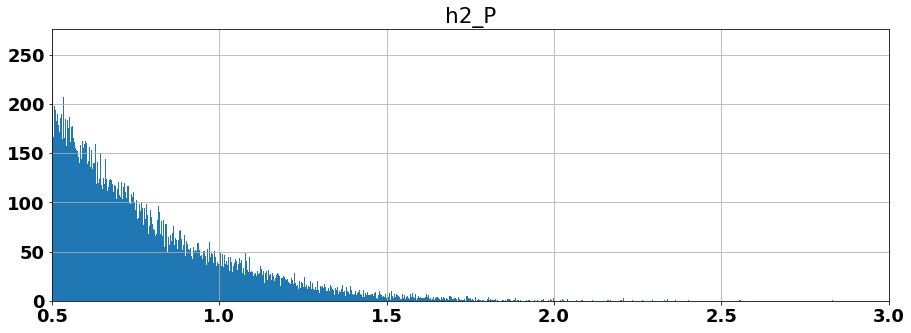

In [42]:
# Testing some distributions
#print (df['Pb'].keys())
#df_mc['Fe'].eval('Xb=Q2/(2*0.938272*nu)', inplace=True)
#df['Pb'].hist(figsize=(12,12),bins=100,column=['h1_StatCC','h2_StatCC', 'h1_Nphe', 'h2_Chi2CC'])
#plt.show()

df['Pb'].eval('h1_P=sqrt(h1_z*nu*h2_z*nu-0.13957*0.13957)', inplace=True)
df['Pb'].eval('h2_P=sqrt(h2_z*nu*h2_z*nu-0.13957*0.13957)', inplace=True)
df['Pb'].query('Q2>1').hist(
    figsize=(15,5),bins=1000,column=['h2_P'])
plt.xlim(0.5,3)
plt.show()



# Nominal case result plot
**The idea here is to make sure the code is working fine, I should reproduce what I had before**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

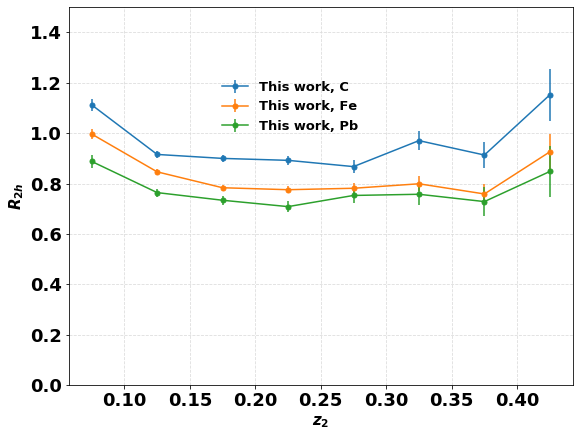

In [7]:
fig = plt.figure(figsize=(8,6))

p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)


for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    print('for target ',target, ' : ',(err_nom/r_nom)*100)
    plt.errorbar(x_nom,r_nom,yerr = err_nom  ,  fmt='-o',ms=5, label='This work, %s'%target)  
plt.grid(axis="x",color='gainsboro', linestyle='dashed')
plt.grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=1.0, top=1.0)    
fig.legend(loc='upper center',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
plt.ylim([0.,1.5])
plt.ylabel('$R_{2h}$',fontsize=15,fontweight="bold")
plt.xlabel('$z_{2}$',fontsize=15,fontweight="bold")

#print('for target ',target, ' : ',(err_nom/r_nom)*100)

plt.show()

# $\color{red}{\textbf{Getting the ratio of nominal case and variations}}$

**$\Delta Z$ Variations**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

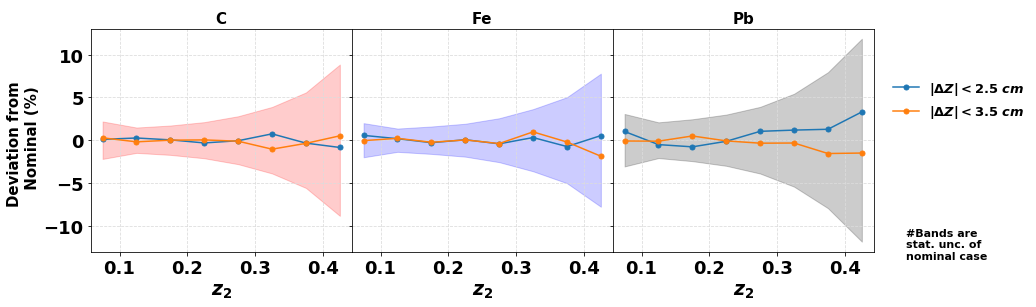

In [8]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$|\Delta Z|<2.5$ $cm$','$|\Delta Z|<3.5$ $cm$']

p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<2.5 and abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.5 and abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$z_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
plt.savefig('diH_DeltaZ.pdf', bbox_inches='tight')

plt.show()

**With respect to $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

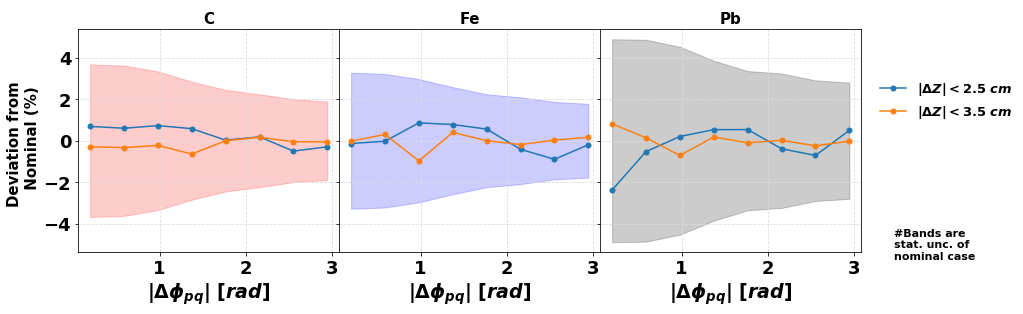

In [9]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$|\Delta Z|<2.5$ $cm$','$|\Delta Z|<3.5$ $cm$']

p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<2.5 and abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.5 and abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi', 
                                    pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi_{pq}|$ $[rad]$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
plt.savefig('diH_DeltaZ_dphi.pdf', bbox_inches='tight')

plt.show()

**With respect to the Dipion mass (GeV)**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

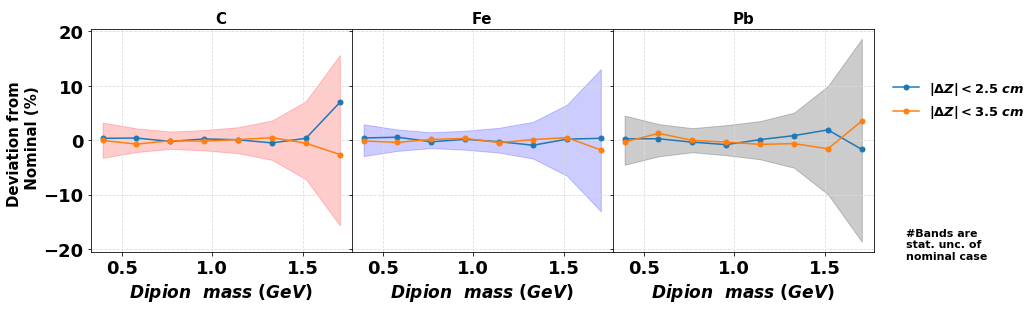

In [10]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$|\Delta Z|<2.5$ $cm$','$|\Delta Z|<3.5$ $cm$']

p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<2.5 and abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.5 and abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                    pair_cut = '%s and h2_z>0.1'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$Dipion$  $mass$ $(GeV)$',fontsize=17,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
plt.savefig('diH_DeltaZ_dpionMass.pdf', bbox_inches='tight')

plt.show()

**Vertex selection variation**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

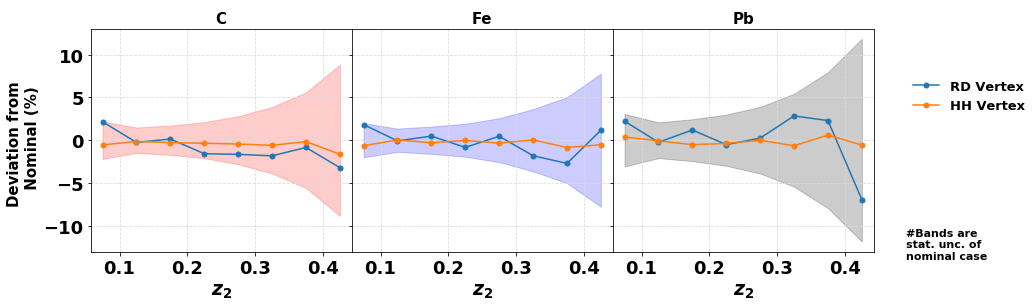

In [11]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['RD Vertex','HH Vertex']
p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$z_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
plt.savefig('diH_VertexCuts.pdf', bbox_inches='tight')

plt.show()




**With respect to $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

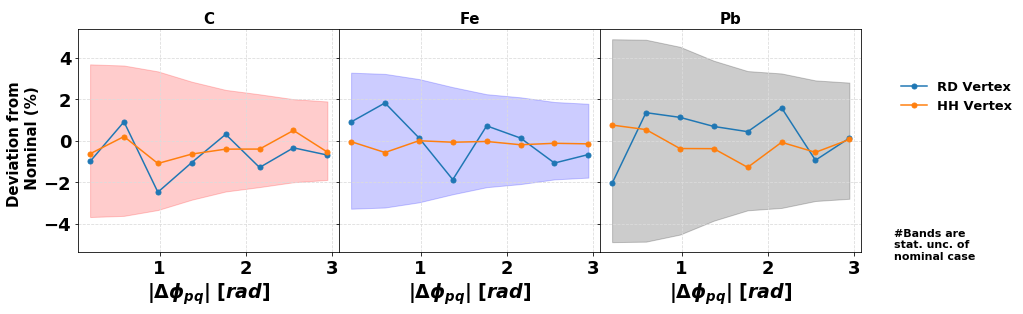

In [12]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['RD Vertex','HH Vertex']
p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14,  variable='dphi', 
                                    pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14,  variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi_{pq}|$ $[rad]$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
plt.savefig('diH_VertexCuts_dphi.pdf', bbox_inches='tight')

plt.show()



**With respect to the Dipion mass (GeV)**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

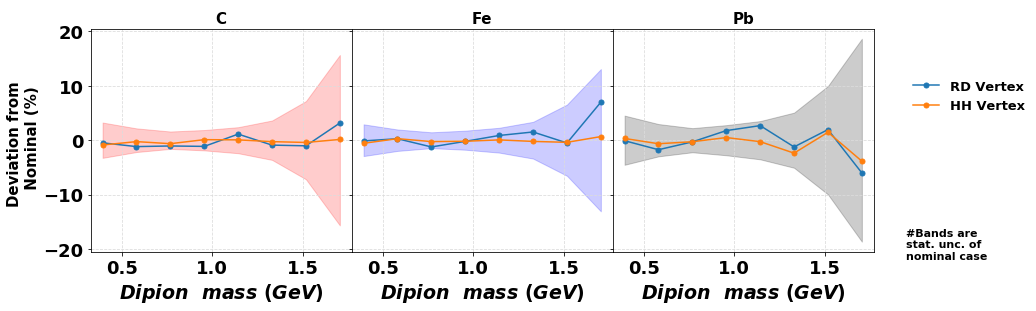

In [28]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['RD Vertex','HH Vertex']
p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                    pair_cut = '%s and h2_z>0.1'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass',  
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass',  
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$Dipion$  $mass$ $(GeV)$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
plt.savefig('diH_VertexCuts_dpionMass.pdf', bbox_inches='tight')

plt.show()


# Sector variations

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  

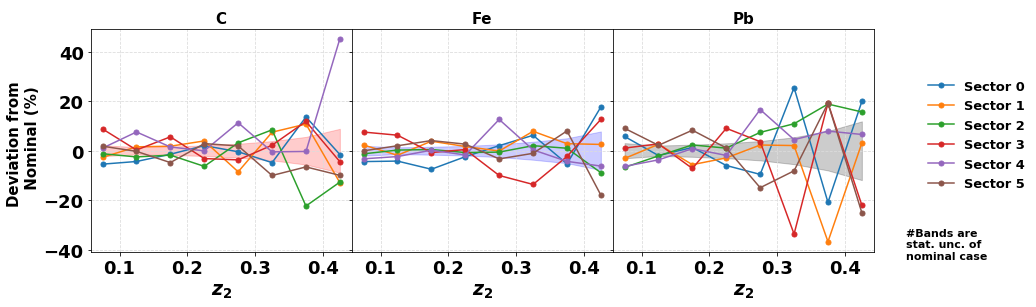

In [11]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Sector 0','Sector 1','Sector 2','Sector 3','Sector 4','Sector 5']
p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var1='%s and h1_Sector==0'%pair_cut_nom
pair_cut_var2='%s and h1_Sector==1'%pair_cut_nom
pair_cut_var3='%s and h1_Sector==2'%pair_cut_nom
pair_cut_var4='%s and h1_Sector==3'%pair_cut_nom
pair_cut_var5='%s and h1_Sector==4'%pair_cut_nom
pair_cut_var6='%s and h1_Sector==5'%pair_cut_nom

#trigger_cut_var1 = '%s and h1_Sector==0'%trigger_cut_nom
#trigger_cut_var2 = '%s and h1_Sector==1'%trigger_cut_nom
#trigger_cut_var3 = '%s and h1_Sector==2'%trigger_cut_nom
#trigger_cut_var4 = '%s and h1_Sector==3'%trigger_cut_nom
#trigger_cut_var5 = '%s and h1_Sector==4'%trigger_cut_nom
#trigger_cut_var6 = '%s and h1_Sector==5'%trigger_cut_nom

trigger_cut_var1 = '%s '%trigger_cut_nom
trigger_cut_var2 = '%s '%trigger_cut_nom
trigger_cut_var3 = '%s '%trigger_cut_nom
trigger_cut_var4 = '%s '%trigger_cut_nom
trigger_cut_var5 = '%s '%trigger_cut_nom
trigger_cut_var6 = '%s '%trigger_cut_nom



for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut=trigger_cut_var2)   
    
    r_var3, err_var3,x_var3 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var3,
                                       trig_cut=trigger_cut_var3)
    r_var4, err_var4,x_var4 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var4,
                                       trig_cut=trigger_cut_var4)
    
    r_var5, err_var5,x_var5 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var5,
                                       trig_cut=trigger_cut_var5)
    r_var6, err_var6,x_var6 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var6,
                                       trig_cut=trigger_cut_var6)

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    y_dev_nom_var3 =  ((r_var3 - r_nom)/ r_nom )*100.
    y_dev_nom_var4 =  ((r_var4 - r_nom)/ r_nom )*100.
    y_dev_nom_var5 =  ((r_var5 - r_nom)/ r_nom )*100.
    y_dev_nom_var6 =  ((r_var6 - r_nom)/ r_nom )*100.    
    
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")
    axs[i].errorbar(x_nom,y_dev_nom_var3,fmt='-o',ms=5,label=tmp_label[2]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var4,fmt='-o',ms=5,label=tmp_label[3]if i == 0 else "")
    axs[i].errorbar(x_nom,y_dev_nom_var5,fmt='-o',ms=5,label=tmp_label[4]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var6,fmt='-o',ms=5,label=tmp_label[5]if i == 0 else "")    
    
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$z_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

plt.show()

**With respect to $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  

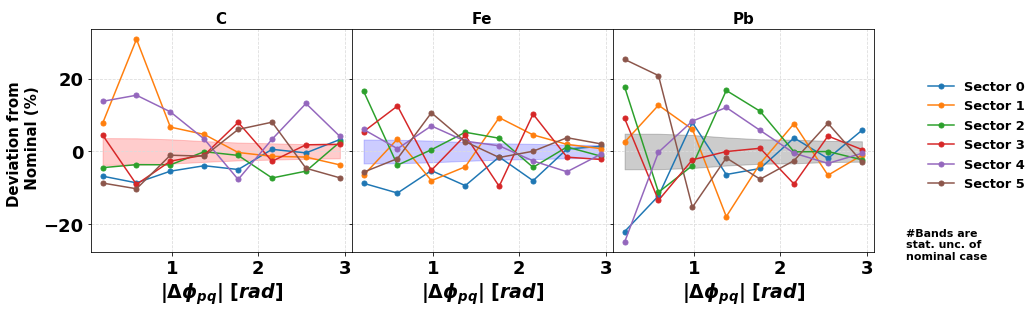

In [13]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Sector 0','Sector 1','Sector 2','Sector 3','Sector 4','Sector 5']
p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var1='%s and h1_Sector==0'%pair_cut_nom
pair_cut_var2='%s and h1_Sector==1'%pair_cut_nom
pair_cut_var3='%s and h1_Sector==2'%pair_cut_nom
pair_cut_var4='%s and h1_Sector==3'%pair_cut_nom
pair_cut_var5='%s and h1_Sector==4'%pair_cut_nom
pair_cut_var6='%s and h1_Sector==5'%pair_cut_nom

#trigger_cut_var1 = '%s and h1_Sector==0'%trigger_cut_nom
#trigger_cut_var2 = '%s and h1_Sector==1'%trigger_cut_nom
#trigger_cut_var3 = '%s and h1_Sector==2'%trigger_cut_nom
#trigger_cut_var4 = '%s and h1_Sector==3'%trigger_cut_nom
#trigger_cut_var5 = '%s and h1_Sector==4'%trigger_cut_nom
#trigger_cut_var6 = '%s and h1_Sector==5'%trigger_cut_nom

trigger_cut_var1 = '%s '%trigger_cut_nom
trigger_cut_var2 = '%s '%trigger_cut_nom
trigger_cut_var3 = '%s '%trigger_cut_nom
trigger_cut_var4 = '%s '%trigger_cut_nom
trigger_cut_var5 = '%s '%trigger_cut_nom
trigger_cut_var6 = '%s '%trigger_cut_nom



for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi',  
                                    pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi',  
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)   
    
    r_var3, err_var3,x_var3 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var3,
                                       trig_cut=trigger_cut_var3)
    r_var4, err_var4,x_var4 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var4,
                                       trig_cut=trigger_cut_var4)
    
    r_var5, err_var5,x_var5 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var5,
                                       trig_cut=trigger_cut_var5)
    r_var6, err_var6,x_var6 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var6,
                                       trig_cut=trigger_cut_var6)

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    y_dev_nom_var3 =  ((r_var3 - r_nom)/ r_nom )*100.
    y_dev_nom_var4 =  ((r_var4 - r_nom)/ r_nom )*100.
    y_dev_nom_var5 =  ((r_var5 - r_nom)/ r_nom )*100.
    y_dev_nom_var6 =  ((r_var6 - r_nom)/ r_nom )*100.    
    
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")
    axs[i].errorbar(x_nom,y_dev_nom_var3,fmt='-o',ms=5,label=tmp_label[2]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var4,fmt='-o',ms=5,label=tmp_label[3]if i == 0 else "")
    axs[i].errorbar(x_nom,y_dev_nom_var5,fmt='-o',ms=5,label=tmp_label[4]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var6,fmt='-o',ms=5,label=tmp_label[5]if i == 0 else "")    
    
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi_{pq}|$ $[rad]$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

plt.show()

**With respect to the Dipion mass (GeV)**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))   
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  

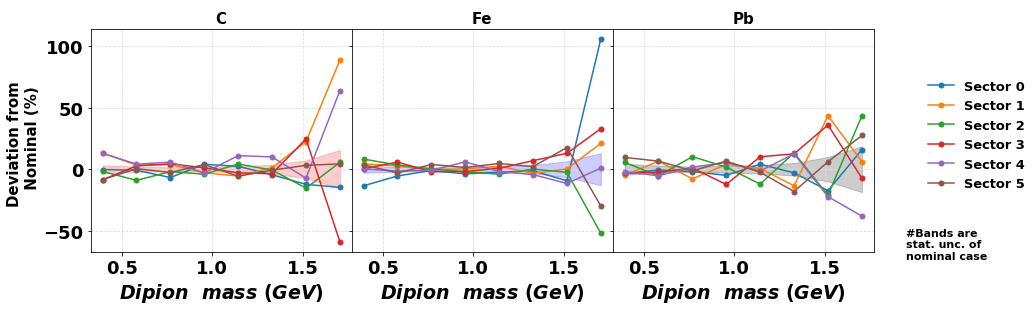

In [29]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Sector 0','Sector 1','Sector 2','Sector 3','Sector 4','Sector 5']
p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var1='%s and h1_Sector==0'%pair_cut_nom
pair_cut_var2='%s and h1_Sector==1'%pair_cut_nom
pair_cut_var3='%s and h1_Sector==2'%pair_cut_nom
pair_cut_var4='%s and h1_Sector==3'%pair_cut_nom
pair_cut_var5='%s and h1_Sector==4'%pair_cut_nom
pair_cut_var6='%s and h1_Sector==5'%pair_cut_nom

#trigger_cut_var1 = '%s and h1_Sector==0'%trigger_cut_nom
#trigger_cut_var2 = '%s and h1_Sector==1'%trigger_cut_nom
#trigger_cut_var3 = '%s and h1_Sector==2'%trigger_cut_nom
#trigger_cut_var4 = '%s and h1_Sector==3'%trigger_cut_nom
#trigger_cut_var5 = '%s and h1_Sector==4'%trigger_cut_nom
#trigger_cut_var6 = '%s and h1_Sector==5'%trigger_cut_nom

trigger_cut_var1 = '%s '%trigger_cut_nom
trigger_cut_var2 = '%s '%trigger_cut_nom
trigger_cut_var3 = '%s '%trigger_cut_nom
trigger_cut_var4 = '%s '%trigger_cut_nom
trigger_cut_var5 = '%s '%trigger_cut_nom
trigger_cut_var6 = '%s '%trigger_cut_nom



for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass',  
                                    pair_cut = '%s and h2_z>0.1'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass',  
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)   
    
    r_var3, err_var3,x_var3 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var3,
                                       trig_cut=trigger_cut_var3)
    r_var4, err_var4,x_var4 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass',  
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var4,
                                       trig_cut=trigger_cut_var4)
    
    r_var5, err_var5,x_var5 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var5,
                                       trig_cut=trigger_cut_var5)
    r_var6, err_var6,x_var6 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass',  
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var6,
                                       trig_cut=trigger_cut_var6)

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    y_dev_nom_var3 =  ((r_var3 - r_nom)/ r_nom )*100.
    y_dev_nom_var4 =  ((r_var4 - r_nom)/ r_nom )*100.
    y_dev_nom_var5 =  ((r_var5 - r_nom)/ r_nom )*100.
    y_dev_nom_var6 =  ((r_var6 - r_nom)/ r_nom )*100.    
    
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")
    axs[i].errorbar(x_nom,y_dev_nom_var3,fmt='-o',ms=5,label=tmp_label[2]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var4,fmt='-o',ms=5,label=tmp_label[3]if i == 0 else "")
    axs[i].errorbar(x_nom,y_dev_nom_var5,fmt='-o',ms=5,label=tmp_label[4]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var6,fmt='-o',ms=5,label=tmp_label[5]if i == 0 else "")    
    
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$Dipion$  $mass$ $(GeV)$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

plt.show()

# Sampling Fraction variation

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

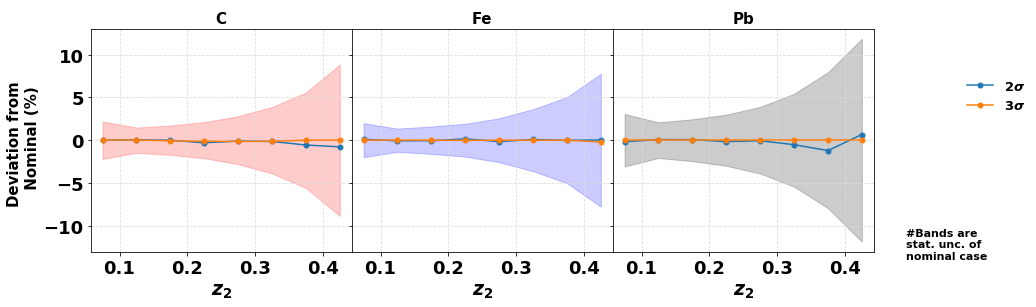

In [14]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['2$\sigma$','3$\sigma$']
p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

# by default the cut is at 3 sigmas

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)



for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$z_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim(-0.5,0.5)
plt.savefig('diH_SamplingFraction.pdf', bbox_inches='tight')

plt.show()



**With respect to $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

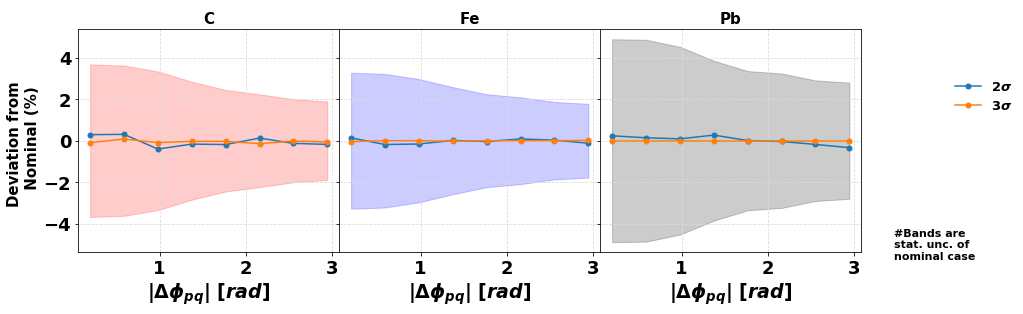

In [15]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['2$\sigma$','3$\sigma$']
p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

# by default the cut is at 3 sigmas

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)



for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14,  variable='dphi', 
                                    pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14,  variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14,  variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi_{pq}|$ $[rad]$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim(-0.5,0.5)
plt.savefig('diH_SamplingFraction_dphi.pdf', bbox_inches='tight')

plt.show()



**With respect to the Dipion mass (GeV)**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

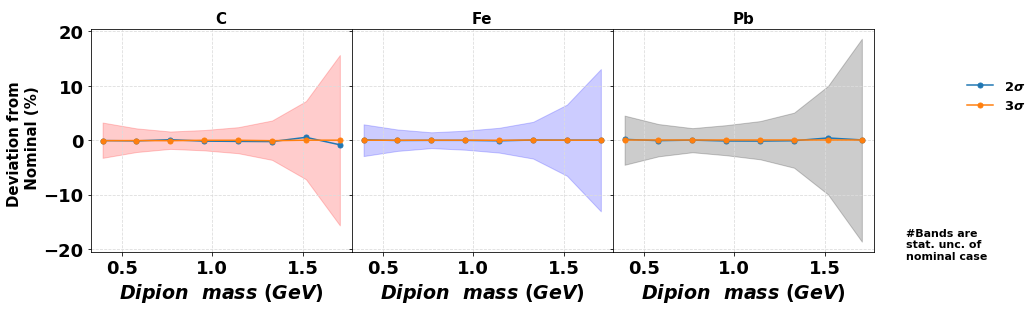

In [30]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['2$\sigma$','3$\sigma$']
p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

# by default the cut is at 3 sigmas

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)



for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                    pair_cut = '%s and h2_z>0.1'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$Dipion$  $mass$ $(GeV)$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim(-0.5,0.5)
plt.savefig('diH_SamplingFraction_dpionMass.pdf', bbox_inches='tight')

plt.show()



# $z_{1}$ threshold value, for the trigger

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.52 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.52 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 )) 

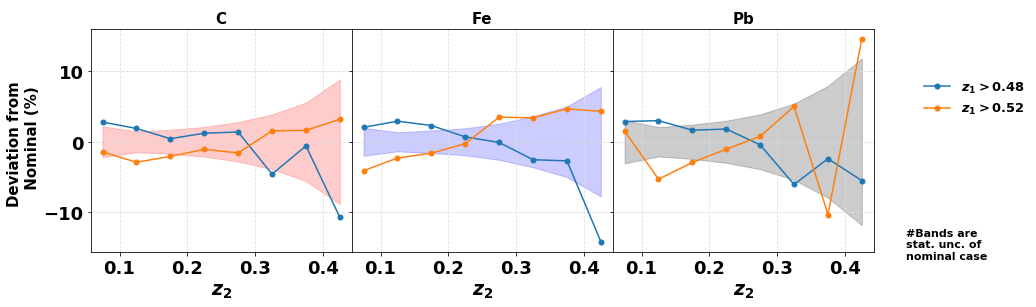

In [13]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$z_{1}>0.48$','$z_{1}>0.52$']
p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var1  ='and h1_z>0.48 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.48 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var2  ='and h1_z>0.52 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.52 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)


for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$z_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

plt.show()

**With respect to $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.52 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.52 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 )) 

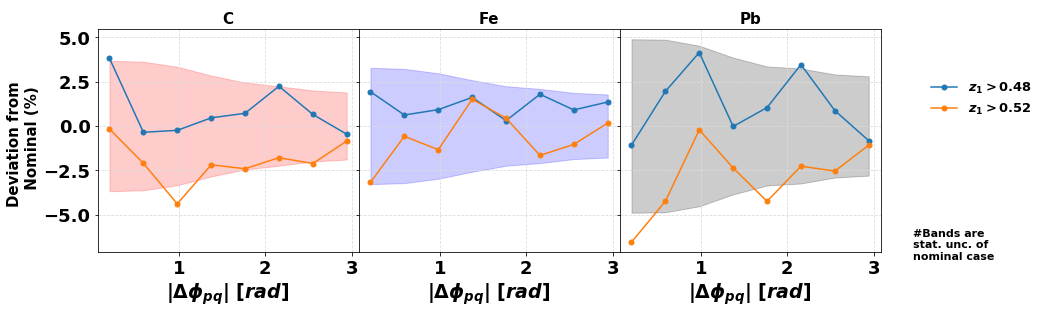

In [17]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$z_{1}>0.48$','$z_{1}>0.52$']
p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var1  ='and h1_z>0.48 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.48 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var2  ='and h1_z>0.52 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.52 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)


for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi',  
                                    pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi',  
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14, variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi_{pq}|$ $[rad]$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

plt.show()

**With respect to the Dipion mass (GeV)**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.52 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.52 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 )) 

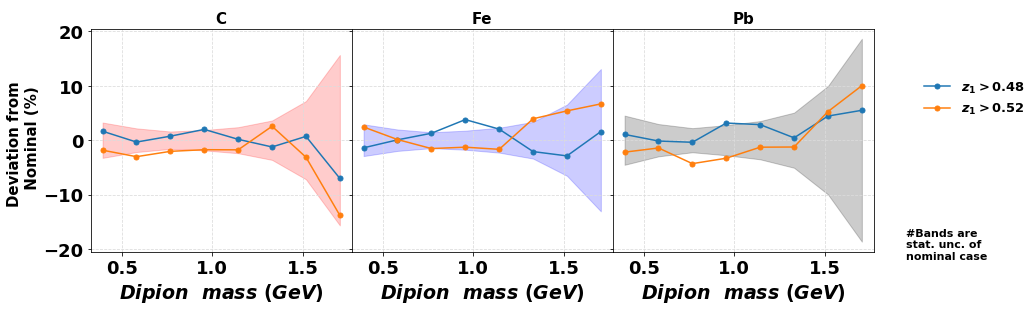

In [31]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$z_{1}>0.48$','$z_{1}>0.52$']
p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var1  ='and h1_z>0.48 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.48 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var2  ='and h1_z>0.52 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.52 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)


for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass',  
                                    pair_cut = '%s and h2_z>0.1'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass',  
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$Dipion$  $mass$ $(GeV)$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

plt.show()

# Nphe for $\pi^{+}$ selection

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

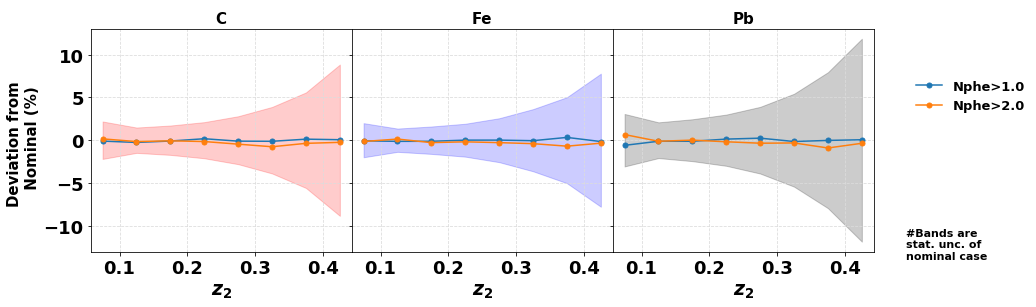

In [68]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Nphe>1.0','Nphe>2.0']
p_thr=2.7
Nphe_thr_nom=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr_nom,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr_nom,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

Nphe_thr_var1=10
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr,p_thr,p_thr,p_thr)                    

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut,StatCC_h1_cut)


Nphe_thr_var2=20
Nphe_h1_cut_var2='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr_var2,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut_var2='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr_var2,p_thr,p_thr,p_thr,p_thr)                    

pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var2, Nphe_h2_cut_var2,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var2, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$z_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-1.5,1.5])
plt.savefig('diH_Nphethreshold_piPlus.pdf', bbox_inches='tight')

plt.show()

**With respect to $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

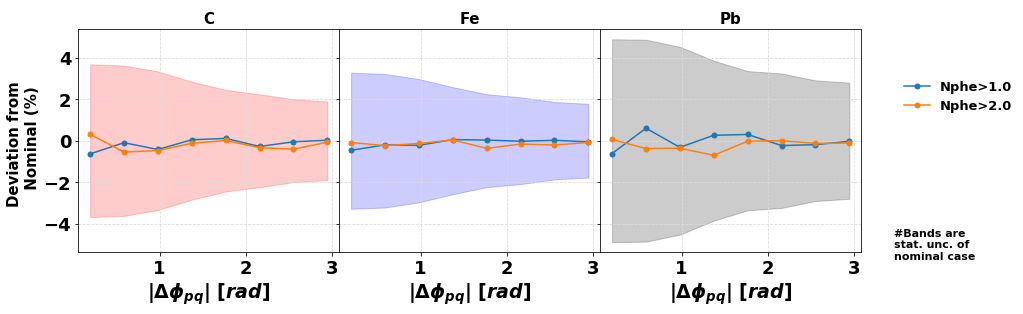

In [18]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Nphe>1.0','Nphe>2.0']
p_thr=2.7
Nphe_thr_nom=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr_nom,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr_nom,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

Nphe_thr_var1=10
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr,p_thr,p_thr,p_thr)                    

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut,StatCC_h1_cut)


Nphe_thr_var2=20
Nphe_h1_cut_var2='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr_var2,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut_var2='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr_var2,p_thr,p_thr,p_thr,p_thr)                    

pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var2, Nphe_h2_cut_var2,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var2, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14,  variable='dphi', 
                                    pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14,  variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14,  variable='dphi',  
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi_{pq}|$ $[rad]$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-1.5,1.5])
plt.savefig('diH_Nphethreshold_piPlus_dphi.pdf', bbox_inches='tight')

plt.show()

**With respect to the Dipion mass (GeV)**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

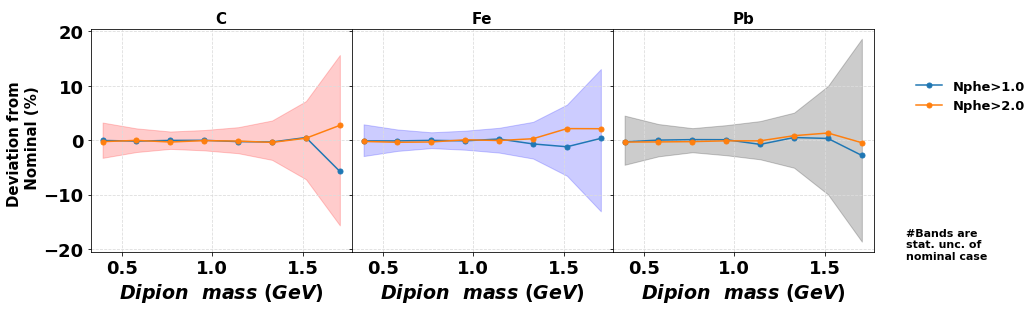

In [32]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Nphe>1.0','Nphe>2.0']
p_thr=2.7
Nphe_thr_nom=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr_nom,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr_nom,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

Nphe_thr_var1=10
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr,p_thr,p_thr,p_thr)                    

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut,StatCC_h1_cut)


Nphe_thr_var2=20
Nphe_h1_cut_var2='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr_var2,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut_var2='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr_var2,p_thr,p_thr,p_thr,p_thr)                    

pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var2, Nphe_h2_cut_var2,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var2, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass',  
                                    pair_cut = '%s and h2_z>0.1'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass',  
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$Dipion$  $mass$ $(GeV)$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-1.5,1.5])
plt.savefig('diH_Nphethreshold_piPlus_dpionMass.pdf', bbox_inches='tight')

plt.show()

# P theshold  for $\pi^{+}$ selection

In [19]:
%%time
path_data="/home/seba/di-hadron/P25"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    df['P25%s'%target]=getdatainChunks('%s/Pairs_%s.root'%(path_data,target), target)
    df['P25D_%s'%target]= getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    df_trigger['P25%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                      '%s_trigger'%target)
    df_trigger['P25D_%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                        'D_%s_trigger'%target)

Getting dataframes from target C
Get trigger dataframes from deuterium target C
Getting dataframes from target Fe
Get trigger dataframes from deuterium target Fe
Getting dataframes from target Pb
Get trigger dataframes from deuterium target Pb
CPU times: user 4.73 s, sys: 194 ms, total: 4.92 s
Wall time: 4.92 s


In [20]:
%%time
path_data="/home/seba/di-hadron/P30"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    df['P30%s'%target]=getdatainChunks('%s/Pairs_%s.root'%(path_data,target), target)
    df['P30D_%s'%target]= getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    df_trigger['P30%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                      '%s_trigger'%target)
    df_trigger['P30D_%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                        'D_%s_trigger'%target)

Getting dataframes from target C
Get trigger dataframes from deuterium target C
Getting dataframes from target Fe
Get trigger dataframes from deuterium target Fe
Getting dataframes from target Pb
Get trigger dataframes from deuterium target Pb
CPU times: user 5.18 s, sys: 330 ms, total: 5.51 s
Wall time: 5.5 s


In [21]:
%%time
for key in df.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print ('\nkey: ',key)
    df[key] = applyCuts(df[key],isMC=isMC)
    df[key] = applyCutsPair(df[key],isMC=isMC)

for key in df_trigger.keys():
    print (key)
    df_trigger[key] = applyCuts(df_trigger[key],isTrigger=True)
    print (' ')   


key:  C
Entries before cut  129233
Q2>1.0 and Q2<4.0 129233  (100.00  %)
inelasticity < 0.85 129233  (100.00  %)
h1_pid = pions (trigger) 129233  (100.00  %)
Nu>2.2 and Nu<4.2 129233  (100.00  %)
h1_z <1.0 129233  (100.00  %)
h1_p <5.0 129233  (100.00  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 129233  (100.00  %)
2.2 < nu < 4.2 129233  (100.00  %)
secondary hadrons are pions 129233  (100.00  %)
0.2<h2_p<5.0 129233  (100.00  %)
0.2<h1_p<5.0 129233  (100.00  %)
h1_z<1.0 129233  (100.00  %)
h2_z<1.0 129233  (100.00  %)
10<h2_th<120 129233  (100.00  %)
Theta/P fiducial region selected 129233  (100.00  %)
10< h1_th<120 129233  (100.00  %)
Theta/P fiducial region selected for trigger 129233  (100.00  %)

key:  D_C
Entries before cut  182301
Q2>1.0 and Q2<4.0 182301  (100.00  %)
inelasticity < 0.85 182301  (100.00  %)
h1_pid = pions (trigger) 182301  (100.00  %)
Nu>2.2 and Nu<4.2 182301  (100.00  %)
h1_z <1.0 182301  (100.00  %)
h1_p <5.0 182301  (100.00  %)
Starting ele

0.2<h1_p<5.0 268658  (100.00  %)
h1_z<1.0 268658  (100.00  %)
h2_z<1.0 268654  (100.00  %)
10<h2_th<120 268654  (100.00  %)
Theta/P fiducial region selected 268654  (100.00  %)
10< h1_th<120 268654  (100.00  %)
Theta/P fiducial region selected for trigger 268654  (100.00  %)

key:  P30C
Entries before cut  133939
Q2>1.0 and Q2<4.0 133939  (100.00  %)
inelasticity < 0.85 133939  (100.00  %)
h1_pid = pions (trigger) 133939  (100.00  %)
Nu>2.2 and Nu<4.2 131486  (98.17  %)
h1_z <1.0 131453  (99.97  %)
h1_p <5.0 131453  (100.00  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 131453  (100.00  %)
2.2 < nu < 4.2 131453  (100.00  %)
secondary hadrons are pions 131453  (100.00  %)
0.2<h2_p<5.0 131453  (100.00  %)
0.2<h1_p<5.0 131453  (100.00  %)
h1_z<1.0 131453  (100.00  %)
h2_z<1.0 131451  (100.00  %)
10<h2_th<120 131451  (100.00  %)
Theta/P fiducial region selected 131451  (100.00  %)
10< h1_th<120 131451  (100.00  %)
Theta/P fiducial region selected for trigger 131451  (100.0

h1_pid = pions (trigger) 922773  (100.00  %)
Nu>2.2 and Nu<4.2 909271  (98.54  %)
h1_z <1.0 908261  (99.89  %)
h1_p <5.0 908261  (100.00  %)
 
P30Fe_trigger
Entries before cut  799926
Q2>1.0 and Q2<4.0 799925  (100.00  %)
inelasticity < 0.85 799925  (100.00  %)
h1_pid = pions (trigger) 799925  (100.00  %)
Nu>2.2 and Nu<4.2 787812  (98.49  %)
h1_z <1.0 787204  (99.92  %)
h1_p <5.0 787204  (100.00  %)
 
P30D_Fe_trigger
Entries before cut  1367739
Q2>1.0 and Q2<4.0 1367739  (100.00  %)
inelasticity < 0.85 1367739  (100.00  %)
h1_pid = pions (trigger) 1367739  (100.00  %)
Nu>2.2 and Nu<4.2 1349994  (98.70  %)
h1_z <1.0 1348615  (99.90  %)
h1_p <5.0 1348615  (100.00  %)
 
P30Pb_trigger
Entries before cut  296838
Q2>1.0 and Q2<4.0 296838  (100.00  %)
inelasticity < 0.85 296838  (100.00  %)
h1_pid = pions (trigger) 296838  (100.00  %)
Nu>2.2 and Nu<4.2 291820  (98.31  %)
h1_z <1.0 291582  (99.92  %)
h1_p <5.0 291582  (100.00  %)
 
P30D_Pb_trigger
Entries before cut  1425843
Q2>1.0 and Q2<4.0 

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.139

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.139

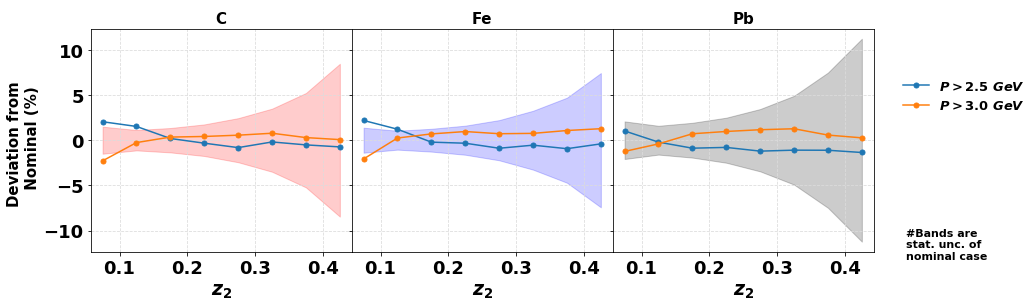

In [22]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$P>2.5$ $GeV$','$P>3.0$ $GeV$']

## I put a crazy high value for P, basically it means 'do not apply the cuts'. 
#That is because they are already in the source files
p_thr_nom=700
Nphe_thr_nom=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

p_thr_var1=700
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

p_thr_var2=700
Nphe_thr_var2=15
Nphe_h1_cut_var2='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
Nphe_h2_cut_var2='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)                    
Chi2CC_h1_cut_var2='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
Chi2CC_h2_cut_var2='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
StatCC_h1_cut_var2='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr_var2,p_thr_var2)
StatCC_h2_cut_var2='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr_var2,p_thr_var2)

pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var2, Nphe_h2_cut_var2,Chi2CC_h1_cut_var2,Chi2CC_h2_cut_var2,StatCC_h1_cut_var2, StatCC_h2_cut_var2)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var2, Chi2CC_h1_cut_var2,StatCC_h1_cut_var2)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = getRatio(df['P25%s'%target], df['P25D_%s'%target], 
                        df_trigger['P25%s_trigger'%target], df_trigger['P25D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = getRatio(df['P30%s'%target], df['P30D_%s'%target], 
                        df_trigger['P30%s_trigger'%target], df_trigger['P30D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut = trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$z_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-0.5,0.5])
plt.savefig('diH_Pthreshold_piPlus.pdf', bbox_inches='tight')

plt.show()

**With respect to $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.139

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.139

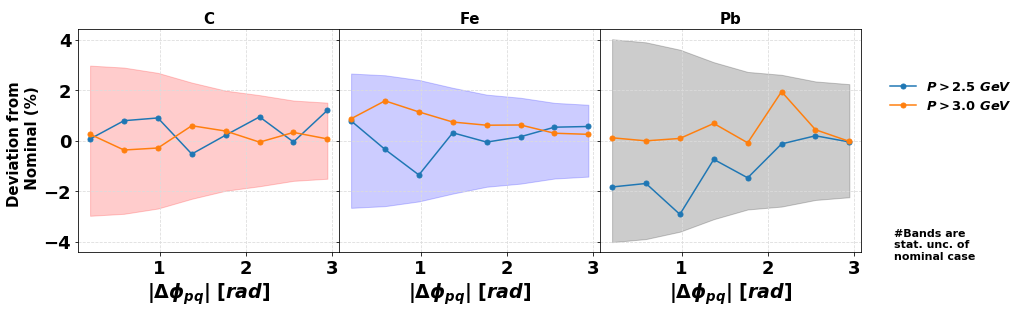

In [23]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$P>2.5$ $GeV$','$P>3.0$ $GeV$']

## I put a crazy high value for P, basically it means 'do not apply the cuts'. 
#That is because they are already in the source files
p_thr_nom=700
Nphe_thr_nom=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

p_thr_var1=700
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

p_thr_var2=700
Nphe_thr_var2=15
Nphe_h1_cut_var2='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
Nphe_h2_cut_var2='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)                    
Chi2CC_h1_cut_var2='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
Chi2CC_h2_cut_var2='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
StatCC_h1_cut_var2='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr_var2,p_thr_var2)
StatCC_h2_cut_var2='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr_var2,p_thr_var2)

pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var2, Nphe_h2_cut_var2,Chi2CC_h1_cut_var2,Chi2CC_h2_cut_var2,StatCC_h1_cut_var2, StatCC_h2_cut_var2)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var2, Chi2CC_h1_cut_var2,StatCC_h1_cut_var2)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14,  variable='dphi', 
                                    pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = getRatio(df['P25%s'%target], df['P25D_%s'%target], 
                        df_trigger['P25%s_trigger'%target], df_trigger['P25D_%s_trigger'%target],
                        minz=0.0,maxz=3.14,  variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = getRatio(df['P30%s'%target], df['P30D_%s'%target], 
                        df_trigger['P30%s_trigger'%target], df_trigger['P30D_%s_trigger'%target],
                        minz=0.0,maxz=3.14,  variable='dphi',
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut = trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi_{pq}|$ $[rad]$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-0.5,0.5])
plt.savefig('diH_Pthreshold_piPlus_dphi.pdf', bbox_inches='tight')

plt.show()

**With respect to the Dipion mass (GeV)**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.139

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700*700) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.139

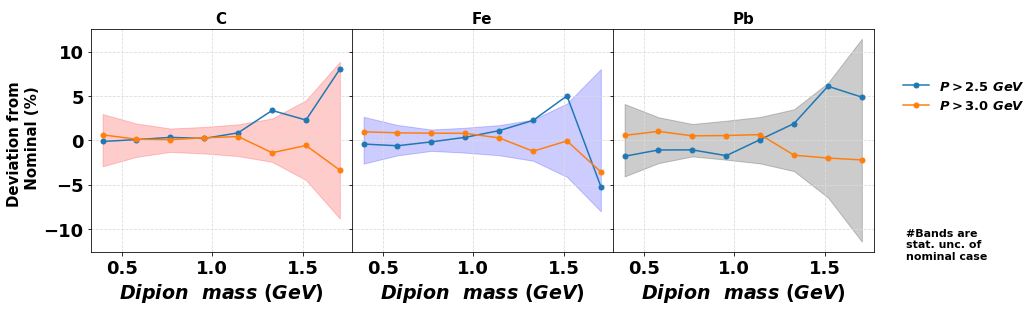

In [33]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$P>2.5$ $GeV$','$P>3.0$ $GeV$']

## I put a crazy high value for P, basically it means 'do not apply the cuts'. 
#That is because they are already in the source files
p_thr_nom=700
Nphe_thr_nom=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

p_thr_var1=700
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

p_thr_var2=700
Nphe_thr_var2=15
Nphe_h1_cut_var2='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
Nphe_h2_cut_var2='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)                    
Chi2CC_h1_cut_var2='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
Chi2CC_h2_cut_var2='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
StatCC_h1_cut_var2='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr_var2,p_thr_var2)
StatCC_h2_cut_var2='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr_var2,p_thr_var2)

pair_cut_var2  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var2, Nphe_h2_cut_var2,Chi2CC_h1_cut_var2,Chi2CC_h2_cut_var2,StatCC_h1_cut_var2, StatCC_h2_cut_var2)
trigger_cut_var2   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var2, Chi2CC_h1_cut_var2,StatCC_h1_cut_var2)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                    pair_cut = '%s and h2_z>0.1'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = getRatio(df['P25%s'%target], df['P25D_%s'%target], 
                        df_trigger['P25%s_trigger'%target], df_trigger['P25D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass',  
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = getRatio(df['P30%s'%target], df['P30D_%s'%target], 
                        df_trigger['P30%s_trigger'%target], df_trigger['P30D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var2,
                                       trig_cut = trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$Dipion$  $mass$ $(GeV)$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-0.5,0.5])
plt.savefig('diH_Pthreshold_piPlus_dpionMass.pdf', bbox_inches='tight')

plt.show()

# CC Matching Mirror v/s Nphe for $\pi^{-}$ rejection from electron sample

In [24]:
%%time
path_data="/home/seba/di-hadron/CC_Matching"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    df['CC%s'%target]=getdatainChunks('%s/Pairs_%s.root'%(path_data,target), target)
    df['CCD_%s'%target]= getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    df_trigger['CC%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                      '%s_trigger'%target)
    df_trigger['CCD_%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                        'D_%s_trigger'%target)


Getting dataframes from target C
Get trigger dataframes from deuterium target C
Getting dataframes from target Fe
Get trigger dataframes from deuterium target Fe
Getting dataframes from target Pb
Get trigger dataframes from deuterium target Pb
CPU times: user 22.4 s, sys: 959 ms, total: 23.4 s
Wall time: 23.4 s


In [60]:
print(df_trigger.keys())

dict_keys(['C_trigger', 'D_C_trigger', 'Fe_trigger', 'D_Fe_trigger', 'Pb_trigger', 'D_Pb_trigger', 'P25C_trigger', 'P25D_C_trigger', 'P25Fe_trigger', 'P25D_Fe_trigger', 'P25Pb_trigger', 'P25D_Pb_trigger', 'P30C_trigger', 'P30D_C_trigger', 'P30Fe_trigger', 'P30D_Fe_trigger', 'P30Pb_trigger', 'P30D_Pb_trigger', 'CCC_trigger', 'CCD_C_trigger', 'CCFe_trigger', 'CCD_Fe_trigger', 'CCPb_trigger', 'CCD_Pb_trigger'])


In [25]:
%%time
for key in df.keys():
    isMC = False
    if 'CC' in key:
        print ('\nkey: ',key)
        df[key] = applyCuts(df[key],isMC=isMC)
        df[key] = applyCutsPair(df[key],isMC=isMC)

for key in df_trigger.keys():
    if 'CC' in key:
        print (key)
        df_trigger[key] = applyCuts(df_trigger[key],isTrigger=True)
        print (' ')   


key:  CCC
Entries before cut  1393282
Q2>1.0 and Q2<4.0 1393282  (100.00  %)
inelasticity < 0.85 1393282  (100.00  %)
h1_pid = pions (trigger) 272628  (19.57  %)
Nu>2.2 and Nu<4.2 267937  (98.28  %)
h1_z <1.0 267844  (99.97  %)
h1_p <5.0 267844  (100.00  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 267844  (100.00  %)
2.2 < nu < 4.2 267844  (100.00  %)
secondary hadrons are pions 135810  (50.70  %)
0.2<h2_p<5.0 135810  (100.00  %)
0.2<h1_p<5.0 135810  (100.00  %)
h1_z<1.0 135810  (100.00  %)
h2_z<1.0 135808  (100.00  %)
10<h2_th<120 135808  (100.00  %)
Theta/P fiducial region selected 135808  (100.00  %)
10< h1_th<120 135808  (100.00  %)
Theta/P fiducial region selected for trigger 135808  (100.00  %)

key:  CCD_C
Entries before cut  1235940
Q2>1.0 and Q2<4.0 1235940  (100.00  %)
inelasticity < 0.85 1235940  (100.00  %)
h1_pid = pions (trigger) 336721  (27.24  %)
Nu>2.2 and Nu<4.2 331267  (98.38  %)
h1_z <1.0 331160  (99.97  %)
h1_p <5.0 331160  (100.00  %)
Starting 

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

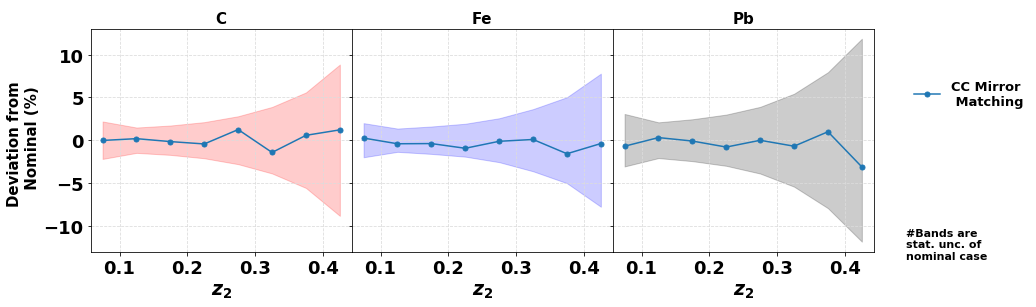

In [26]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['CC Mirror \n Matching']

## I put a crazy high value for P, basically it means 'do not apply the cuts'. 
#That is because they are already in the source files
p_thr_nom=2.7
Nphe_thr_nom=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)


for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = getRatio(df['CC%s'%target], df['CCD_%s'%target], 
                        df_trigger['CC%s_trigger'%target], df_trigger['CCD_%s_trigger'%target],
                        minz=0.05,maxz=0.45, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$z_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-0.5,0.5])
plt.savefig('diH_CCMatching.pdf', bbox_inches='tight')

plt.show()

**With respect to $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

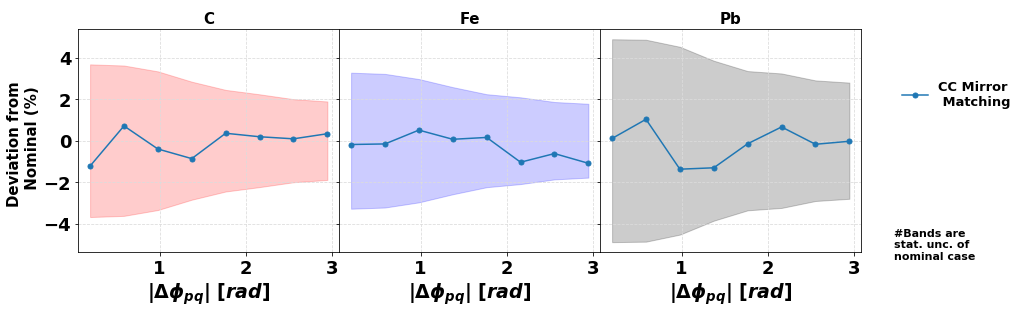

In [27]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['CC Mirror \n Matching']

## I put a crazy high value for P, basically it means 'do not apply the cuts'. 
#That is because they are already in the source files
p_thr_nom=2.7
Nphe_thr_nom=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)


for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14,  variable='dphi',
                                    pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = getRatio(df['CC%s'%target], df['CCD_%s'%target], 
                        df_trigger['CC%s_trigger'%target], df_trigger['CCD_%s_trigger'%target],
                        minz=0.0,maxz=3.14,  variable='dphi', 
                                       pair_cut = '%s and h2_z>0.1 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi_{pq}|$ $[rad]$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-0.5,0.5])
plt.savefig('diH_CCMatching_dphi.pdf', bbox_inches='tight')

plt.show()

**With respect to the Dipion mass (GeV)**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2*2) and h1_pid==211 ) -1 ))  a

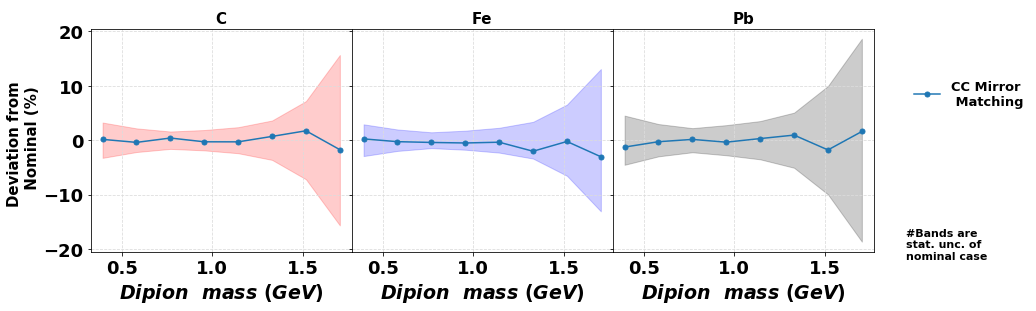

In [34]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['CC Mirror \n Matching']

## I put a crazy high value for P, basically it means 'do not apply the cuts'. 
#That is because they are already in the source files
p_thr_nom=2.7
Nphe_thr_nom=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr_nom,p_thr_nom,p_thr_nom,p_thr_nom)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr_nom,p_thr_nom)

pair_cut_nom  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%d*%d) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%d*%d) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and h2_FidCut==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCut==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass', 
                                    pair_cut = '%s and h2_z>0.1'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = getRatio(df['CC%s'%target], df['CCD_%s'%target], 
                        df_trigger['CC%s_trigger'%target], df_trigger['CCD_%s_trigger'%target],
                        minz=0.3,maxz=1.8, variable='pair_mass',  
                                       pair_cut = '%s and h2_z>0.1'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$Dipion$  $mass$ $(GeV)$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-0.5,0.5])
plt.savefig('diH_CCMatching_dpionMass.pdf', bbox_inches='tight')

plt.show()